# Odkrivanje skupin in izris kart dokumentov na podlagi besed specifičnih za skupine

Dimenzionalnost vektorskih predstavitev dokumentov lahko zmanjšamo na 2, kar nam omogoča prikaz dvodimenzionalne karte dokumentov, na kateri vsaka točka predstavlja dokument. Poleg tega lahko v dvodimenzionalnem prostoru odkrijemo skupine podobnih dokumentov in vsako skupino na karti obarvamo z različno barvo. To nam omogoča dober vpogled v celotno množico dokumentov.

V tem za razliko od _03_03_document_maps.ipynb_ postopamo nekoliko drugače. Dokumente  opišemo samo s specifičnimi besedami za skupine in na podlagi teh izrišemo karto. Za vektorsko predstavitev besedil uporabimo TF-IDF, ker so vreče besed najbolj primerne za izbiro samo določenih besed.

In [1]:
import numpy as np
from textsemantics.server_api import ServerAPI
import string
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from lemmagen.lemmatizer import Lemmatizer
from lemmagen import DICTIONARY_SLOVENE
from sklearn.feature_extraction.text import TfidfVectorizer
from hdbscan import HDBSCAN
from matplotlib import pyplot as plt
import seaborn as sns
from umap import UMAP
from IPython.display import display, Markdown

/Users/primoz/miniconda3/envs/orange3/lib/python3.8/site-packages/umap/__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")


Za začetek si preko API-ja pridobimo besedila zadnjih 100 predlogov vladi, ki vsebujejo vsaj 50 znakov ter iz datoteke preberemo fastText vektorje iz prejšnjega primera.

In [2]:
nltk.download('stopwords', quiet=True)

def preprocess(corpus):
    stop_words = set(stopwords.words('slovene'))
    tokenizer = RegexpTokenizer("\w+")
    lemmatizer = Lemmatizer(dictionary=DICTIONARY_SLOVENE)
    
    preprocessed = list()
    for text in corpus:
        text = text.translate(text.maketrans('', '', string.punctuation))
        tokens = tokenizer.tokenize(text.lower())
        tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words 
                  and len(token) > 2 and not token.isnumeric()]
        preprocessed.append(tokens)
        
    return preprocessed

api = ServerAPI()
metadata = api.get_metadata('predlogi-vladi', sample_size=100, sampling_strategy='latest')

texts = api.get_texts(urls=metadata['text'])
texts = [text for text in texts if len(text) > 50]

tokens_list = preprocess(texts)
print("Število dokumentov:", len(tokens_list))

Število dokumentov: 99


Besedila predstavimo z vektorji s pomočjo metode TF-IDF. 

In [3]:
joined_texts = [' '.join(tokens) for tokens in tokens_list]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(joined_texts)
feature_names = vectorizer.get_feature_names()
print("Dokumenti so opisani z vektorji dolžine", len(feature_names))

Dokumenti so opisani z vektorji dolžine 2270


Poiščimo skupine dokumentov z metodo HDBSCAN.

In [4]:
hdbscan = HDBSCAN(min_cluster_size=4, min_samples=1).fit(X)
labels = hdbscan.labels_

In [5]:
print("Našli smo", len(set(labels) - {-1}), "skupin")
print("V skupine je razvrščenih", np.sum(labels >= 0), "dokumentov")

Našli smo 5 skupin
V skupine je razvrščenih 36 dokumentov


Sedaj izluščimo samo značilke, ki predstavljajo pojavitve ključnih besed za skupine. Vzamemo 50 najbolj pomembnih besed za skupine. Obenem izberemo še 5 najblj pomembnih besed za vsako skupino, ki jih bomo potrebovali kasneje.

In [6]:
ind = set()
cluster_describers = []
for cl in set(labels) - {-1}:
    ids = np.argsort(np.mean(X[labels == cl].toarray(), axis=0))[-50:]
    ind |= set(ids)
    cluster_describers.append([feature_names[i] for i in ids[-5:]])
X_new = X[:, list(ind)].toarray()
print("Število značilk-besed, ki opisujejo nov prostor:", X_new.shape[1])

Število značilk-besed, ki opisujejo nov prostor: 226


Izračunamo vložitve in izrišemo karto dokumentov, ki temelji na ključnih besedah za skupine dokumentov.

In [7]:
umap = UMAP(n_neighbors=5, min_dist=0.0, metric='cosine', random_state=0).fit(X_new)
emb = umap.embedding_

/Users/primoz/miniconda3/envs/orange3/lib/python3.8/site-packages/umap/umap_.py:125: UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 2860 edges.
It has only fully disconnected 1 vertices.
Use umap.utils.disconnected_vertices() to identify them.
  warn(


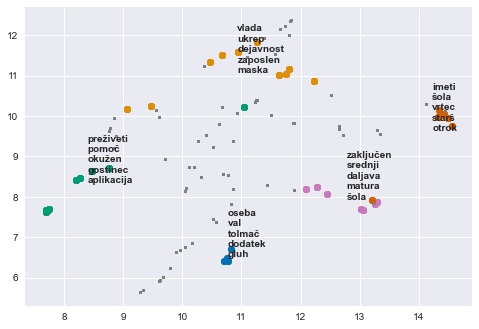

In [11]:
plt.style.use('seaborn')
fig, ax = plt.subplots()
palette = sns.color_palette('colorblind', len(set(labels) - {-1}))
for cl in labels:
    idx = np.where(labels == cl)[0]
    ax.scatter(emb[idx, 0], emb[idx, 1], 
               color=(palette[cl] if cl > -1 else (0.5, 0.5, 0.5)), 
               s=(40 if cl > -1 else 5),
               label=str(cl));

for cluster, words in zip(set(labels) - {-1}, cluster_describers):
    centroid = np.mean(emb[np.where(labels == cluster)[0], :], axis=0)
    ann = "\n".join(words)
    plt.text(centroid[0], centroid[1], ann, fontdict={'fontweight': 'bold'})

Za konec izpišimo še nekaj dokumentov za vsako skupino, da se prepričamo o njihovi smiselnosti.

In [9]:
md = []
for c, words in zip(set(labels) - {-1}, cluster_describers):
    md.append(f'# Skupina {c} ({", ".join(words)})')
    wh = np.where(labels == c)[0]
    md += ["- {}".format(texts[w].replace('\n', '')) for w in wh[:3]]
display(Markdown('\n\n'.join(md)))

# Skupina 0 (oseba, val, tolmač, dodatek, gluh)

- Po Zakonu o osebni asistenci, ki je stopil v veljavo 1.1.2019 vsem osebam z izgubo sluha nad 95% po Fowlerju pripada komunikacijski dodatek v višini cca. 150 EUR mesečno (8. člen).Uveljavljajo ga lahko takoj po postopku, ki je naveden v 9. členu Pravilnika o osebni asistenci.  www.uradni-list.si/glasilo-uradni-list-rs/vsebina/2018-01-2823/praviln...Ta dodatek je mišljen kot neko nadomestilo invalidnine ali dodatka za pomoč in postrežbo, ki osebam z okvaro sluha ne pripada medtem ko mnogim drugim kategorijam invalidnosti vse to pripada. S tem je država nekako le priznala dolgoletno krivico do invalidnosti naglušnih.Naglušni imajo le to smolo, da je njihova invalidnost nevidna. Neka ameriška študija govori o tem, da slepega človeka zlahka prepoznaš in slehernemu vzbuja sočutje medtem pa, ko gluhega človeka ne prepoznaš. Ko to ugotoviš je prva misel strah, ker ne veš kako mu pomagati oziroma kako komunicirati z njim in se rajši umakneš. Zato so slepi deležni nekega spoštljivega spoštovanja medtem, ko so gluhi deležni povsem drugačnih opazkPredlagam, da se sedanji komunikacijski dodatek (150 EUR ) poviša oziroma izenači z DPP, to je 300 EUR.

- Zakon o uporabi slovenskega znakovnega jezika (ur. l. RS št. 96/02 z dne 14.11.2002, v nadaljevanju ZUSZJ) določa pravico gluhih oseb uporabljati slovenski znakovni jezik (v nadaljevanju: znakovni jezik) in pravico gluhih oseb do informiranja v njim prilagojenih tehnikah ter obseg in način uveljavljanja pravice do tolmača za znakovni jezik pri enakopravnem vključevanju gluhih oseb v življenjsko in delovno okolje ter vse oblike družbenega življenja ob enakih pravicah in pogojih ter z enakimi možnostmi, kot jih imajo osebe brez okvare sluha (prvi odstavek 1. člena ZUSZJ).Prvi in tretji odstavek 12. člena ZUSZJ določata: Državni organi, organi lokalne samouprave, izvajalci javnih pooblastil oziroma izvajalci javne službe so dolžni zagotoviti gluhi osebi tolmača za znakovni jezik na zahtevo gluhe osebe ali po uradni dolžnosti takoj, ko gluha oseba predloži na vpogled dokument, s katerim ji je priznana pravica do tolmača. Plačilo stroškov tolmača za znakovni jezik iz prvega odstavka tega člena zagotovijo državni organi, organi lokalne samouprave, izvajalci javnih pooblastil in izvajalci javne službe v letnih finančnih načrtih.Prvi odstavek 13. člena ZUSZJ določa: Pravico do tolmača za znakovni jezik iz drugega odstavka 10. člena tega zakona lahko gluha oseba uveljavlja po lastni presoji v obsegu 30 ur letno, gluha oseba, ki ima status dijaka ali študenta, pa zaradi dodatnih potreb, povezanih z izobraževanjem, lahko tudi več, vendar skupaj največ 100 ur letno.Torej, gluhe osebe, ki imajo status dijaka ali študenta, lahko uporabljajo pravico do tolmača za znakovni jezik po lastni presoji v zadevah, ki se ne odvijajo pred državnimi organi, organi samoupravnih lokalnih skupnosti, nosilci javnih služb ali izvajalci javnih pooblastil (tj. po 13. členu ZUSZJ), v obsegu 100 ur, ostale gluhe osebe pa 30 ur. V 13. členu ZUSZJ je navedeno, da navedena razlika izhaja iz dodatnih potreb, povezanih z izobraževanjem.Toda dodatne potrebe, povezane z izobraževanjem, imamo tudi zaposleni gluhi, saj se moramo zaradi opravljanja svojega poklica neprestano izobraževati. Poleg tega je tudi ogromno različnih strokovnih video vsebin na internetu, povezanih z našimi delovnimi področji, ki niso podnaslovljene ali opremljene s tolmačem za slovenski znakovni jezik, zaradi česar potrebujemo tolmačenje tudi v primeru spremljanja navedenih strokovnih vsebin. Tudi brezposelni gluhi se morajo udeleževati različnih izobraževanj za pridobitev dodatnih znanj, nacionalnih poklicnih kvalifikacij, itd., in tudi tam potrebujejo tolmača za slovenski znakovni jezik.Poleg navedenega so aktivni gluhi (zaposleni, brezposelni), pa tudi gluhi, ki zaradi skrbi za otroka zapustijo trg dela, tudi starši svojim otrokom. Za polno in enakopravno izvajanje starševske vloge pa gluhi starši potrebujejo dovolj ur tolmačenja, da se lahko polnopravno in enakopravno slišečim posvetijo vzgoji svojih otrok in starševskim obveznostim. Starševske obveznosti, kjer bi gluhi starši potrebovali tolmača, so npr: šola za starše (dodatne izobraževalne zahteve!), govorilne ure, roditeljski sestanki (čeprav so roditeljski sestanki in govorilne ure v šolah, ki so izvajalci javnih služb, pa vse prepogosto slišim, da gluhi starši koristijo kvoto tolmačenja na govorilnih urah in roditeljskih sestankih po 13. členu ZUSZJ), itd.Zaradi vsega naštetega je za aktivne gluhe osebe (zaposlene in brezposelne) 30 ur tolmačenja na leto premalo, zaradi česar bi bilo nujno izenačiti število ur tolmačenja, ki pripada aktivnim gluhim (tj. zaposlenim in brezposelnim) ter gluhim staršem, ki skrbijo za otroke do 26. leta starosti, s številom ur tolmačenja, ki pripada gluhim osebam s statusom dijaka ali študenta.Poleg tega bi bilo nujno potrebno povečati število ur tolmačenja gluhim osebam, ki iz v nadaljevanju naštetih razlogov koristijo zdravstvene storitve, ki niso vključene v obvezno in dopolnilno zdravstveno zavarovanje. V navedenem primeru je potrebno namreč koristiti tolmačenje po 13. členu ZUSZJ in ne po 12. členu ZUSZJ. Gre za psihoterapije, ki jih gluhi zaradi stisk, ki jih imajo, še bolj potrebujejo kot slišeči, storitve slišečih društev s področja zdravstva, ki zelo dopolnjujejo ali celo nadomeščajo storitve v okviru zdravstvene dejavnosti, vključene v obvezno in dopolnilno zdravstveno zavarovanje. Npr. če oseba dobi celiakijo, od zdravnika v javni zdravstveni mreži ni deležna pravega izobraževanja o brezglutenski dieti, zaradi česar se mora poslužiti storitev Slovenskega društva za celiakijo, kjer pa mora koristiti tolmačenje po 13. členu ZUSZJ. V navedenem primeru gre spet za dodatne izobraževalne zahteve.Torej, vsem gluhim, ki s kakršnimkoli dokumentom lahko izkažejo povečano potrebo po tolmačenju v slovenski znakovni jezik, naj se omogoči 100 ur tolmačenja letno, v primeru zelo povečane potrebe po tolmačenju pa naj se poveča do ravni, kot jo oseba potrebuje.

- Ob prvem valu je bil dodatek za delo med EPIDEMIOLOGIJE 19 200€. Med drugim valom pa tvegamo glave za minimalne plače (brez dodatkov).Varnostno osebje naj dobi 200€ dodatka do konca epidemije COVID 19 in povrnjene stroške do pravnega vala COVID 19.

# Skupina 1 (vlada, ukrep, dejavnost, zaposlen, maska)

- Pozdravljeni!Zadnje dni prihajajo po medijih do nas volivcev informacije, da je eden od naslednjih možnih ukrepov vlade z namenom zajezitve širjenja okužb s COVID 19 tudi ta, da bi nam omejili gibanje zgolj na naša stanovanja. Glede na to, da določen del prebivalstva svojega dela ne more opravljati na daljavo (zaposleni v zdravstvu) in bo še vedno obstajala možnost širjenja okužbe v delovnih okoljih, ter da za zdravje potrebujemo svež zrak, sonce in gibanje, podajam mnenje, da je tak ukrep nesmiseln.Moj predlog vladi je, da takega ukrepa ne sprejme. Barbara Prosen, dr. med., spec. anesteziologije, reanimatologije in perioperativne intenzivne medicinezaposlena v SB Novo mesto

- Dokazano je da je smrtnost v primeru covid 19 le za 0.04 % večja kot pri gripi. To kaže na nesmiselnost ukrepov. Vladi predlagam da odstrani vse ukrepe zaradi njihove nesmiselnosti upoštevajo pa naj se prostovoljno. Upoštevajo naj jih le tisti ki si to želijo ker so v rizični skupini in je njihov strah pred okužbo utemeljen.

- Predlagam, da se uvede anonimno prijavljanje za zbiranje skupin na določenih mestih in sicer bolj natančno po vaseh, kajti vasi dejansko vsaj naš konec ne, sploh dejansko niso pod nekim nadzorom morebitnega širjenja okužb. Lokalni redar, ki ga imamo tukaj se samo vozi okoli mimo skupin ljudi brez mask, ki se kar nemalo krat zbirajo v gručah. Med njimi nekateri maske nosijo, drugi pa sploh ne. In to od jutra do mraka jeta miks popularna moda na našem koncu. Potem zvečer pride policija in naredi en krog in je dan zaključen. Torej, na podlagi tega predlagam to. Ljudje so obnašajo kot, da so sami na svetu in naj poudarim, da je kar nekaj takih ravno ostarelih ljudi tudi, ki so najbolj ogrožena skupina, med drugimi seveda.

# Skupina 2 (preživeti, pomoč, okužen, gostinec, aplikacija)

- Zaradi zaprtja javnega življenja in tudi gostinskih obratov zaradi Covid19 imajo gostinci bistveno manj prometa. Škodo bi lahko zmanjšali na tak način, da bi vsakemu državljanu omogočili da ima mesečno 10x možnost, da za 30% ceneje naroči hrano pri gostincu; skupna vrednost popustov pa naj ne bi presegala npr.30 do-50€ mesečno. Vsaj polovico popusta bi morali zagotoviti gostinci sami, saj bi jim s tem dejansko reševali poslovno preživetje. Uvesti bi seveda morali ustrezen informacijski sistem, a to ne bi smel biti večji problem, saj bi bila stvar lahko dokaj podobna kot pri turističnih vavčerjih.Hrano bodo seveda dostavljali na dom in naj se koristijo prevozniki, ki so tudi ostali brez dela in ne da gostinci kaj širijo svojo storitev.

- Da bi bile minimalne plače 1200€, da lahko normalno preživiš skozi mesec.

- Predlagam, da vnos kode v aplikacijo postane obvezen za vse osebe, ki so na testiranju prepoznane za pozitivne na SARS - CoV - 2.Strinjam se, da je aplikacija prostovoljna, dokler nismo okuženi in jo v bistvu uporabljamo za to, da smo obveščeni o morebitnih stikih. Povsem drugače pa je, ko smo mi pozitivni in obveščamo druge o tem, da so bili v stiku z nami in da so ogroženi. To pa več ne more biti prostovoljno. To je naša dolžnost. In ker se veliko govori o tem, da epidemiologi in NIJZ sledenja več ne izvajajo ter da je obveščanje prepuščeno posamezniku, bi to bila rešitev za lažje sledenje in obveščanje. Moj predlog gre tudi v to smer, da bi vnos kode direktno izvedel ali upravljalec aplikacije ali operater direktno in ne bi bilo potrebno, da vnaša kodo posameznik.Menim, da bi obvezen vnos v primeru pozitivneg testa v veliki meri prispeval k uspešnosti sledenja okužb in s tem uspešnosti aplikacijeHvala in lep pozdrav,Andreja Kranjc

# Skupina 3 (imeti, šola, vrtec, starš, otrok)

- Otroci v prvih treh razredih osnovne šole se ne morejo šolati na daljavo, ne da bi starši pri tem sodelovali. Številni starši smo samozaposleni in si ne moremo vzeti dopusta, ne da bi pri tem utrpeli izpad dohodka, poleg tega imamo projekte, ki jih ne moremo kar odpovedati, ker bomo izgubili stranke in s tem dolgoročni vir dela in prihodkov.V prvem valu je bil način poučevanja prepuščen posameznim učiteljem in smo bili preuščeni sami sebi. Torej smo opravljali svoje delo in še delo učitelja. Po dveh mesecih smo bili starši izčrpani.Tudi če šola zagotovi pouk po zoomu, lahko to traja največ nekaj ur na dan, saj za majhne otroke ni primerno niti zdravo, da sedijo za računalniškimi ekrani ves dan. To pomeni, da je treba v preostalem delovnem času poskrbeti za varstvo, ki ga mnogi nimamo. Mnogi starši so tudi samohranilci, mnogi imajo po več otrok, ki so vsi v osnovni šoli. Mislim, da to, da otroci ostanejo doma, ni vzdržno.Če ne gre drugače, lahko tudi prepustite ravnateljem v posameznih občinah, da se glede na epidemiološko sliko v tisti občini odločijo, ali naj bo šola odprta ali ne in za katere razrede. 

- Nerazumno je, da ostajajo šole zaprte, saj majhni otroci ne morejo biti sami, niti se ne morejo sami učiti. Ali sploh kdo pomisli na starše, ki morajo delati, a nimajo kam z otroki ( niso vsi v službah, kjer lahko kar ostanejo doma). Marsikdo je porabil še zadnji dopust v upanju, da se bo ta norija končala. Na robu obupa so ljudje, ki nimajo sredstev za preživetje, ki nimajo možnosti za učenje svojih otrok. Vse pridobljene pravice otrok so kar na hitro poteptane. Le zakaj smo za talce vzeli otroke, če vemo, da nevarnost preži na starejše, ki pa jih sedaj itak brez problema porivamo k otrokom kjer je to le možno. Koga pravzaprav ščitimo, vse bolj se zdi, da nikogar.Učitelji dobijo 100% plačo, da razpošljejo učne liste s pomočjo katerih potem starši /stari starši učijo otroke. Vsa skrb za šolanje je preložena iz učiteljev na starše, ali pa sploh na nikogar,Nekateri otroci so se prvič srečali s šolo, nekateri še brati ne znajo, če pa že, bodo itak vse pozabili, nekateri so v višjih razredih, a brez pomoči ne bodo zmogli. Kakšna katastrofa za njihovo prihodnost. Ne poveličujte šole na daljavo, ne sprenevedajte se, kako je vse v redu, ker ni. Kdor ima otroke in mu je zanje mar ve, kako to izgleda in, da je hvaljenje tega zgolj metanje peska v oči. Oglasijo se strokovnjaki, psihologi, a jih nihče ne posluša, še manj sliši.Pametne države niso zaprle šol, naša pa najbolj zapira ravno to, kar je res nujno. Ogromno je izjem, ljudje se sprehajajo tudi čez mejo, seveda če spadajo med priviligirane. Če bi res želeli ukrepati, bi morali ukrepi veljati za vse - tako pa....Kdor je situiran mu tudi šolanje otrok ni problem, kdor pa se bori za preživetje bo obupal in ubogi ti otroci, ki pa jih ni malo. Samo žal ubogih se niti ne vidi niti ne sliši.Sem starejša generacija in nočem več slišati, da ste solidarni s starejšimi, saj smo mi zdaj, če le zmoremo, v prvih "bojnih" vrstah. Virus bo odšel strašne posledice pa bodo ostale. Nasilje se največkrat rodi iz obupa, pa tudi iz neznanja in brezdelja. Otroci se morajo z nečim zaposliti, s počitnicami in šolanjem na daljavo zagotovo ne. Preveč imajo časa za vse neumnosti, iz dolgočasja pa nekaj pač morajo početi in to zagotovo ne samo pametne stvari. Zato ne jemljimo izobrazbe mladim, saj s tem, ko niso v šoli, zagotovo niso vedno v dobrem , še manj pa v varnem okolju.Sicer pa kaže da šole in učiteljev pravzaprav niti ne bomo več potrebovali, saj so vendar vsi starši zmožni spremljati učni proces in razložiti otrokom vse, kar je potrebno. Super, koliko bi lahko država prihranila!!!

- Zanima me, zakaj so lahko odprti zavodi za otroke/mladostnike/odrasle s PP(posebnimi potrebami) in ne razvojni oddelki v vrtcih? Otroci, ki obiskujejo razvojni oddelek so v letih kjer je lahko največji dosežek pri razvoju (3-6let). Starši takšnega otroka niso strokovno izobraženi za izvajanje vaj in terapij doma.Takšnim otrokom delate nepopravljivo škodo! Na dolgi rok vzgajamo sociopate, saj se otrok sploh ne bo znal vključiti v družbo, če je večino časa sam doma s enim od staršev.Če ste lahko odprli oddelke za otroke, kateri so starši primorani oditi v službo, odprite tudi razvojne oddelke za boljšo prihodnost otrok s PP.

# Skupina 4 (zaključen, srednji, daljava, matura, šola)

- Predlagam, da se šola na daljavo podaljša do konca prvega poletja v onovnih in srednjih šolah oz. prvega semestra na fakultetah. Šolo na daljavo predlagam od 5. razreda osnovne šole naprej, razen za učence s posebnimi potrebami in učno pomočjo. Najbolj se covid-19 da zajeziti s študiranjem na daljavo na fakultetah saj tam si gibljejo študenje iz različnih krajev, nenormalna gužva je na javnih prevozih in so tudi najbolj samostojni pri učenju na daljavo.

- Podaljšanja počitnic si medtem ne želijo na srednjih šolah, je sporočila predsednica Društva ravnateljev srednjih šol Nives Počkar, ki poudarja, da so na pouk na daljavo dobro pripravljeni, nadomeščanje pa bi bilo prenaporno.To je odločitev Društva ravnateljev srednjih šol. V kolikor bi upoštevali poglede dijakov, bi bila odločitev drugačna. Njim so šole prvenstveno namenjene. Se je kdo vprašal ali ni šolanje na daljavo za dijake prenaporno ?Tako Nemčija in Francija zagovarjata stališče, da bodo šole zapirali, ko res ne bo več nobenih drugih možnosti.Prav tako so naredili analizo posledic zapiranja šol v prvem valu korona krize. Rezultati so zelo zaskrbljujoči. V Sloveniji pa seveda te analize ni. Posledično so tudi ukrepi temu primerni. 

- Nekateri srednješolci imamo počasi že dovolj šole na daljavo, ker nam nič ne koristi. Še posebej zdaj ne, ker nas čaka matura in mislim, da je čas za ponovno odprtje srednjih šol. Če ne za vse pa samo za tiste, ki imamo maturo in zaključni izpit.